In [23]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

In [24]:
df = pd.read_csv("Data/CICIDS_balanced_171k.csv")
print(df.shape)
print(df['Attack Type'].value_counts())
df.head()

(171000, 53)
Attack Type
Normal Traffic    60000
DoS               30000
DDoS              25000
Port Scanning     25000
Brute Force       15000
Web Attacks       10000
Bots               6000
Name: count, dtype: int64


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,80,5121659,3,12,6,0,4.0,3.464102,0,0,...,17922,2,20,0.0,0,0,0.0,0,0,Normal Traffic
1,53,128476,1,53,53,53,53.0,0.000000,116,116,...,-1,0,32,0.0,0,0,0.0,0,0,Normal Traffic
2,53,23701,1,53,53,53,53.0,0.000000,69,69,...,-1,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,54549,4,2,0,0,0,0.0,0.000000,0,0,...,-1,0,20,0.0,0,0,0.0,0,0,Normal Traffic
4,53,252129,1,58,58,58,58.0,0.000000,202,202,...,-1,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [52]:
# df.duplicated().sum()
df = df.drop_duplicates()

In [53]:
df.duplicated().sum()

np.int64(0)

In [54]:
df.shape

(151306, 53)

In [55]:
# drop unnecessary columns if any
X = df.drop(columns=['Attack Type'])
y = df['Attack Type']

# encode attack labels
le = LabelEncoder()
y = le.fit_transform(y)

# # scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [56]:
freq = Counter(y)

In [57]:
freq

Counter({np.int64(4): 59999,
         np.int64(3): 30000,
         np.int64(2): 25000,
         np.int64(5): 25000,
         np.int64(1): 7355,
         np.int64(6): 2118,
         np.int64(0): 1834})

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [59]:
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 121044
Test set size: 30262


In [60]:
print("Training Random Forest Model...")

Training Random Forest Model...


In [61]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [62]:
# 2. Scale only after splitting
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
rf_model.fit(X_train_scaled, y_train)
print("\nTraining completed!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.4s



Training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s finished


In [64]:
y_pred = rf_model.predict(X_test_scaled)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [65]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9981164496728571


In [66]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Accuracy: 0.9981 (99.81%)


In [67]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

          Bots       0.97      0.97      0.97       367
   Brute Force       1.00      1.00      1.00      1471
          DDoS       1.00      1.00      1.00      5000
           DoS       1.00      1.00      1.00      6000
Normal Traffic       1.00      1.00      1.00     12000
 Port Scanning       1.00      1.00      1.00      5000
   Web Attacks       1.00      0.98      0.99       424

      accuracy                           1.00     30262
     macro avg       0.99      0.99      0.99     30262
  weighted avg       1.00      1.00      1.00     30262



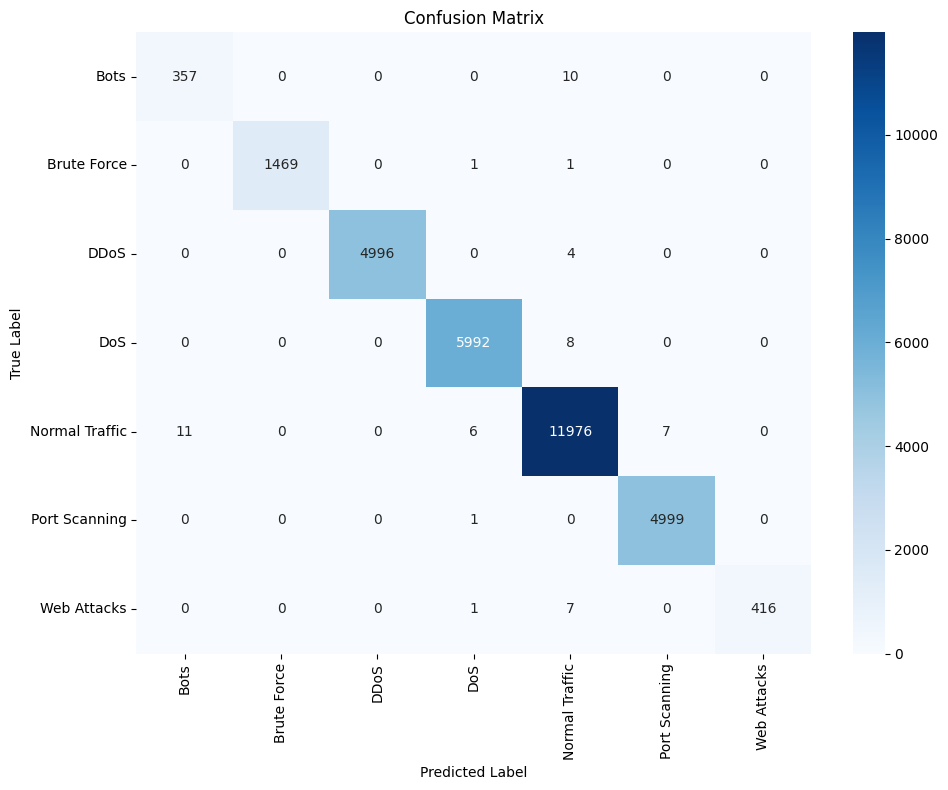

In [68]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
# plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
# print("\nConfusion matrix saved as 'confusion_matrix.png'")

In [69]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))


Top 15 Most Important Features:
                        feature  importance
40          Average Packet Size    0.059122
6        Fwd Packet Length Mean    0.055151
41            Subflow Fwd Bytes    0.053570
4         Fwd Packet Length Max    0.051740
36       Packet Length Variance    0.051540
0              Destination Port    0.049692
3   Total Length of Fwd Packets    0.049284
11        Bwd Packet Length Std    0.045093
33            Max Packet Length    0.041506
34           Packet Length Mean    0.040756
35            Packet Length Std    0.035389
10       Bwd Packet Length Mean    0.034163
43      Init_Win_bytes_backward    0.026311
29            Bwd Header Length    0.026308
31                Bwd Packets/s    0.026187


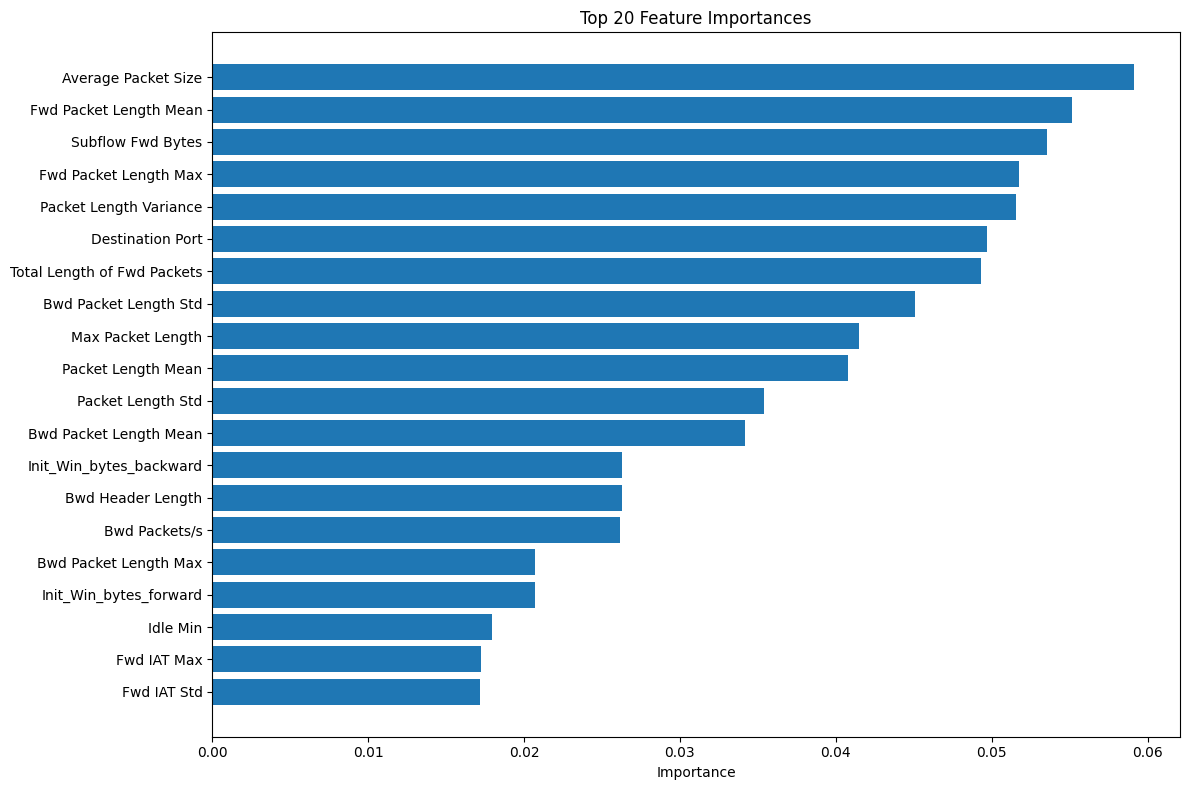

In [70]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
# print("\nFeature importance plot saved as 'feature_importance.png'")


In [71]:
import pickle

with open('rf_intrusion_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("\nModel saved as 'rf_intrusion_model.pkl'")
print("Scaler saved as 'scaler.pkl'")
print("Label encoder saved as 'label_encoder.pkl'")


Model saved as 'rf_intrusion_model.pkl'
Scaler saved as 'scaler.pkl'
Label encoder saved as 'label_encoder.pkl'


In [72]:

def predict_intrusion(new_data):
    # Ensure correct shape
    new_data = np.array(new_data).reshape(1, -1)
    
    # Scale using the same scaler used during training
    new_data_scaled = scaler.transform(new_data)
    
    # Make prediction
    pred_class = rf_model.predict(new_data_scaled)[0]
    pred_prob = rf_model.predict_proba(new_data_scaled)[0]
    
    # Decode label using your trained label encoder
    attack_label = le.inverse_transform([pred_class])[0]
    
    # Confidence score
    confidence = round(np.max(pred_prob) * 100, 2)
    
    print(f"Predicted Attack Type: {attack_label}")
    print(f"Confidence: {confidence}%")
    return attack_label, confidence


'''
def predict_intrusion(new_data):
    # Ensure correct shape
    new_data = np.array(new_data).reshape(1, -1)
    
    # Scale using the same scaler used during training
    # new_data_scaled = scaler.transform(new_data)
    
    # Make prediction
    pred_class = rf_model.predict(new_data)[0]
    pred_prob = rf_model.predict_proba(new_data)[0]
    
    # Decode label using your trained label encoder
    attack_label = le.inverse_transform([pred_class])[0]
    
    # Confidence score
    confidence = round(np.max(pred_prob) * 100, 2)
    
    print(f"Predicted Attack Type: {attack_label}")
    print(f"Confidence: {confidence}%")
    return attack_label, confidence
'''

'\ndef predict_intrusion(new_data):\n    # Ensure correct shape\n    new_data = np.array(new_data).reshape(1, -1)\n\n    # Scale using the same scaler used during training\n    # new_data_scaled = scaler.transform(new_data)\n\n    # Make prediction\n    pred_class = rf_model.predict(new_data)[0]\n    pred_prob = rf_model.predict_proba(new_data)[0]\n\n    # Decode label using your trained label encoder\n    attack_label = le.inverse_transform([pred_class])[0]\n\n    # Confidence score\n    confidence = round(np.max(pred_prob) * 100, 2)\n\n    print(f"Predicted Attack Type: {attack_label}")\n    print(f"Confidence: {confidence}%")\n    return attack_label, confidence\n'

In [89]:
predict_intrusion(X_test.iloc[29000].values)
# print(type(X_test))

Predicted Attack Type: DoS
Confidence: 100.0%


C:\Users\Py147\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


('DoS', np.float64(100.0))

In [21]:
X_test.to_csv("X_test.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [22]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1:", f1)

Macro F1: 0.9984129502720951
